# Some EDA for checking out distribution of activation over cids

In [1]:
%pylab inline
%autosave 25

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Load the interactions data

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

In [3]:
def load_data(path, data_type=None):
    if data_type:
        df = pd.read_csv(path, index_col=0, dtype=data_type)
    else:
        df = pd.read_csv(path, index_col=0)
    print('Number of rows: {:,}\n'.format(len(df)))
    print('Number of columns: {:,}\n'.format(len(df.columns)))
    
    columns_missing_values = df.columns[df.isnull().any()].tolist()
    print('{} columns with missing values: {}\n\n'.format(len(columns_missing_values), columns_missing_values))
    
    cols = df.columns.tolist()
    column_types = [{col: df.dtypes[col].name} for col in cols]
    print('column types:\n')
    print(column_types, '\n\n')
    
    print(df.head())
    
    return df

In [4]:
df_interactions = load_data(data_loc+'interactions.csv')

# Rename the 'canonical_cid' column simply to 'cid' to simplifiy joining to the other feature sets later.
df_interactions.rename(columns={"canonical_cid": "cid"}, inplace=True)
df_interactions.head()

Number of rows: 189,312

Number of columns: 3

0 columns with missing values: []


column types:

[{'canonical_cid': 'int64'}, {'pid': 'object'}, {'activity': 'int64'}] 


   canonical_cid       pid  activity
0          38258  CAA96025         0
1       23644994    P11511         0
2       76314488    P31391         0
3       46225960    Q96DB2         0
4        3005573    P04798         1


,cid,pid,activity
0,38258,CAA96025,0
1,23644994,P11511,0
2,76314488,P31391,0
3,46225960,Q96DB2,0
4,3005573,P04798,1


In [22]:
print('number of interactions where activity == 1: {:,}'.format(len(df_interactions[df_interactions['activity'] == 1])))
print('number of interactions where activity == 0: {:,}'.format(len(df_interactions[df_interactions['activity'] == 0])))

number of interactions where activity == 1: 29,998
number of interactions where activity == 0: 159,314


# Check proportions of active to inactive for drugs

In [5]:
grouped = df_interactions.groupby('cid')['activity'].value_counts()
grouped.head(10)

cid  activity
6    1           17
     0            1
7    0            1
11   1            2
13   1            4
19   1           25
40   1           10
51   1            4
     0            3
66   1            2
Name: activity, dtype: int64

<hr>
Looks like cid 11 has non inactive results.

In [6]:
df_interactions[df_interactions['cid']==11]

,cid,pid,activity
11727,11,P25963,1
120885,11,P0AF67,1


In [7]:
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped.head()

activity_count
cid activity                
6   1                     17
    0                      1
7   0                      1
11  1                      2
13  1                      4

In [8]:
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked.head()

activity_count      
activity              0     1
cid                          
6                   1.0  17.0
7                   1.0   0.0
11                  0.0   2.0
13                  0.0   4.0
19                  0.0  25.0

In [9]:
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)
df_grouped_stacked.head()

,cid,0,1
0,6,1.0,17.0
1,7,1.0,0.0
2,11,0.0,2.0
3,13,0.0,4.0
4,19,0.0,25.0


In [10]:
z = df_grouped_stacked[df_grouped_stacked[1] == 0]
nz = df_grouped_stacked[df_grouped_stacked[1] > 0]
print('there are {:,} drugs with zero activation'.format(len(z)))
print('there are {:,} drugs with an activation'.format(len(nz)))

there are 79,583 drugs with zero activation
there are 8,839 drugs with an activation


In [11]:
print(len(df_grouped_stacked[((df_grouped_stacked[0] == 0) & (df_grouped_stacked[1] > 0))]))
print(len(df_grouped_stacked))

6348
88422


In [12]:
nz.head()

,cid,0,1
0,6,1.0,17.0
2,11,0.0,2.0
3,13,0.0,4.0
4,19,0.0,25.0
5,40,0.0,10.0


In [13]:
z.head()

,cid,0,1
1,7,1.0,0.0
19,135,1.0,0.0
52,264,1.0,0.0
53,273,1.0,0.0
73,341,1.0,0.0


In [14]:
df_interactions[df_interactions['cid'] == 1613]

,cid,pid,activity
109351,1613,O60218,0
151616,1613,P15121,0
154978,1613,P14550,0


### Top 100 cids with >10 active results

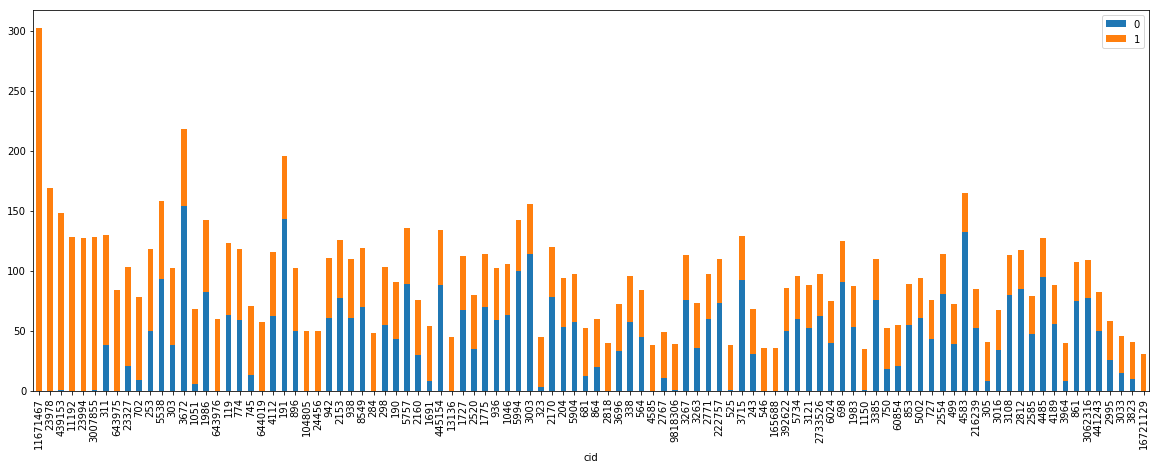

In [15]:
df_sorted = df_grouped_stacked.sort_values(by=[1], ascending=False)
df_sorted[df_sorted[1] > 10][:100].plot.bar(stacked=True, x='cid', y=[0,1], rot=90, figsize=(20,7))

### Bottom 100 cids with >10 active results

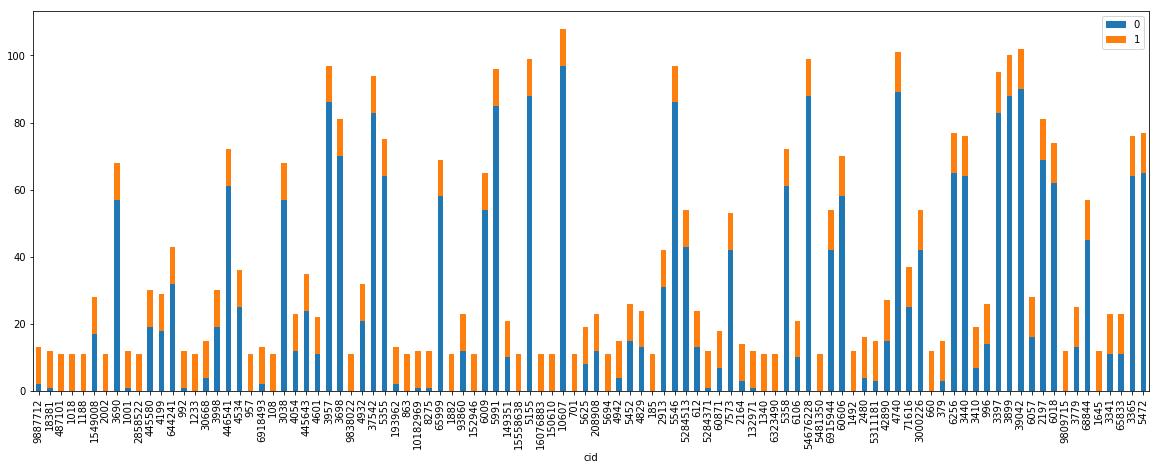

In [16]:
df_sorted = df_grouped_stacked.sort_values(by=[1], ascending=True)
df_sorted[df_sorted[1] > 10][:100].plot.bar(stacked=True, x='cid', y=[0, 1], rot=90, figsize=(20,7))

### Bottom 100 cids re. number of active results (all zero)

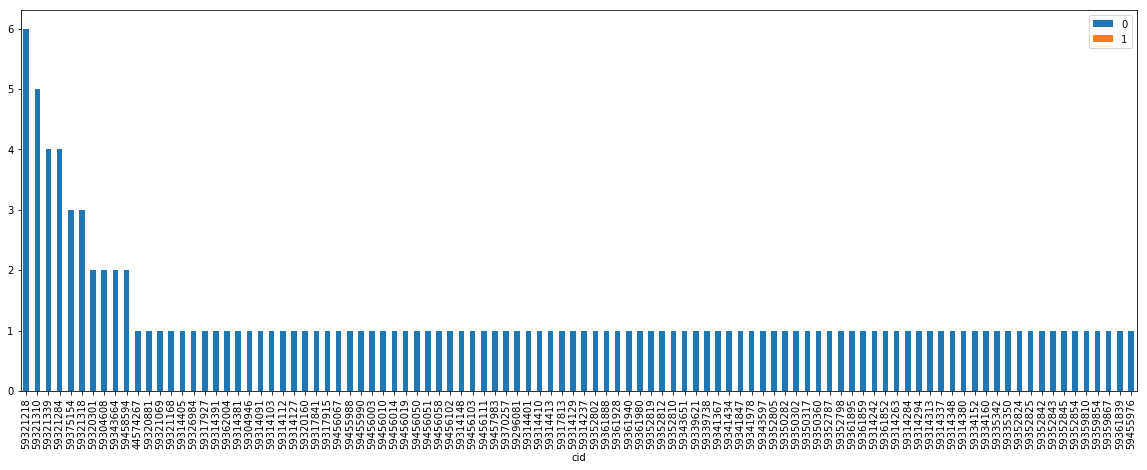

In [17]:
df_sorted = df_grouped_stacked.sort_values(by=[1], ascending=True)[:100].sort_values(by=[0], ascending=False)
df_sorted.plot.bar(stacked=True, x='cid', y=[0, 1], rot=90, figsize=(20,7))